In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import time
import random
from scipy import stats
from scipy.stats import mode
import seaborn as sns
import warnings
from collections import defaultdict
warnings.filterwarnings("ignore")

## Set A indicates SEQUENTIAL MUTATIONS

### Functions

In [3]:
def beta_binomial_p(a_mutated_branches, b_mutated_branches, 
           a_unmutated_branches, b_unmutated_branches, PSEUDOCOUNT_VALUE = 1, verbose=False):
    
    
    """
    Note: this is not the main p-value function and was only tested during initial project stages
    
    Computes p-value of the inferred mu from the non-mutated branches versus the posterior
    distribution of mutated + unmutated branches
    
    """
   #pseudocounting
    if a_mutated_branches ==0:
        return np.nan
    if a_mutated_branches ==0:
        b_mutated_branches += PSEUDOCOUNT_VALUE
    if a_unmutated_branches ==0:
        a_unmutated_branches += PSEUDOCOUNT_VALUE
    if b_unmutated_branches ==0:
        b_unmutated_branches += PSEUDOCOUNT_VALUE

    beta_posterior = stats.beta(a=a_unmutated_branches + a_mutated_branches, b=b_unmutated_branches + b_mutated_branches)
    
    prior_mean = a_unmutated_branches/(a_unmutated_branches+b_unmutated_branches)
    
    pval = beta_posterior.cdf(prior_mean)
    if verbose:
        print(f"a_unmutated_branches: {a_unmutated_branches}")
        print(f"b_unmutated_branches: {b_unmutated_branches}")
        print(f"a_mutated_branches: {a_mutated_branches}")
        print(f"b_mutated_branches: {b_mutated_branches}")
        print(f"pvalue:{pval}")

    return pval

def hypergeometric_p(M, N, n, k, verbose=False):
    
    """
    Note: this is not the main p-value function and was only tested during initial project stages
    Computes the p-value of drawing k mutations on mutated branches out of n total mutations
    
    M: total population
    N: number of successes in population (branches with mutation j)
    n: number of draws
    k: number of successful draws
    """

    
    distr = stats.hypergeom(M, n, N)
    pval = 1 - distr.cdf(k - 0.0000001)
    
    
    if verbose:
        print(f"total branches:{M}\ntotal successes:{N}\ntotal draws:{n}\nNumber of successful draws:{k}")
        print(f"pvalue:{pval}")
        
    return pval


def beta_p(a_mutated_branches, b_mutated_branches, 
           a_unmutated_branches, b_unmutated_branches, PSEUDOCOUNT_VALUE = 1, verbose=False):
    
    """
        Computes p-value of the inferred mu from the non-mutated branches versus the beta
    distribution inferred from the mutated branches
    
    Parameters
    ----------
    a_mutated_branches: int
        number of background mutated branches with a mutation event
    b_mutated_branches: int
        number of background mutated branches WITHOUT a mutation event
    a_unmutated_branches: int
        number of background UNmutated branches with a mutation event
    b_unmutated_branches: int
        number of background UNmutated branches WITHOUT a mutation event
    PSEUDOCOUNT_VALUE: int, optional (default: 1)
        because beta distribution parameters must be greater than 0, pseudocount
        value to introduce
    verbose: bool, optional (defualt: False)
        if true, print debugging statements
        
    Note that "a" and "b" here refer to the input parameters of the beta distribution, alpha and beta 

    
    """
    #pseudocounting
    
    if a_mutated_branches ==0:
        return np.nan
    if a_mutated_branches ==0:
        b_mutated_branches += PSEUDOCOUNT_VALUE
    if a_unmutated_branches ==0:
        a_unmutated_branches += PSEUDOCOUNT_VALUE
    if b_unmutated_branches ==0:
        b_unmutated_branches += PSEUDOCOUNT_VALUE

    beta_posterior = stats.beta(a=a_mutated_branches, b=b_mutated_branches)
    
    prior_mean = a_unmutated_branches/(a_unmutated_branches+b_unmutated_branches)
    
    pval = beta_posterior.cdf(prior_mean)
    if verbose:
        print(f"a_unmutated_branches: {a_unmutated_branches}")
        print(f"b_unmutated_branches: {b_unmutated_branches}")
        print(f"a_mutated_branches: {a_mutated_branches}")
        print(f"b_mutated_branches: {b_mutated_branches}")
        print(f"pvalue:{pval}")
        
    return pval

def apply_testing(df, total_branches=None, verbose=False, run_hypergeometric=False, run_betabin=False):
    """
    Function to apply the statistical tests to the dataframe of co-ocurring mutations
    
    Applies the test in both directions, ie tests mutation A -> mutation B and mutation B -> mutation A
    """
    if total_branches is None:
        total_branches = len(np.load("output/00.mutation_data_by_lineage/00.combined_data/all_branches.npy"))
    
    df["total_branches_applicable"] = total_branches - df.n_branch_i_and_j

    df["n_unmutated_branches_i"] = df.total_branches_applicable - df.n_branch_with_i_no_j
    df["n_unmutated_branches_j"] = df.total_branches_applicable - df.n_branch_with_j_no_i
    
    df["n_mutations_i_on_unmutated"] = df.n_mutations_i - df.n_muts_i_on_branch_j
    df["n_mutations_j_on_unmutated"] = df.n_mutations_j  - df.n_muts_j_on_branch_i
    
    if run_hypergeometric:
        print('running hypergeometric i on j')
        df['pval_hypergeo_i_on_j'] = df.apply(lambda row: hypergeometric_p (
            row['total_branches_applicable'] - row["n_branch_with_i_no_j"] - row['n_muts_same_branch'], 
            row['n_branch_with_j_no_i'], 
            row['n_mutations_i'],
            row['n_muts_i_on_branch_j'], verbose=verbose
        ), axis = 1) 
        print('running hypergeometric j on i')
        df['pval_hypergeo_j_on_i'] = df.apply(lambda row: hypergeometric_p (
            row['total_branches_applicable'] - row["n_branch_with_j_no_i"] - row['n_muts_same_branch'], 
            row['n_branch_with_i_no_j'], 
            row['n_mutations_j'],
            row['n_muts_j_on_branch_i'], verbose=verbose
        ), axis = 1) 
    if run_betabin:
        print('running beta-binomial i on j')
        df['pval_betabin_i_on_j'] = df.apply(lambda row: beta_binomial_p (
            row['n_muts_i_on_branch_j'], 
            row['n_branch_with_j_no_i'] - row['n_muts_i_on_branch_j'], 
            row['n_mutations_i_on_unmutated'],
            row["n_unmutated_branches_i"] - row['n_mutations_i_on_unmutated'] -\
            row['n_branch_with_j_no_i']  - row['n_muts_same_branch'], verbose=verbose
        ), axis = 1) 
        print('running beta-binomial j on i')
        df['pval_betabin_j_on_i'] = df.apply(lambda row: beta_binomial_p (
            row['n_muts_j_on_branch_i'], 
            row['n_branch_with_i_no_j'] - row['n_muts_j_on_branch_i'], 
            row['n_mutations_j_on_unmutated'],
            row["n_unmutated_branches_j"] - row['n_mutations_j_on_unmutated'] -\
            row['n_branch_with_i_no_j']  - row['n_muts_same_branch'], verbose=verbose
        ), axis = 1) 
    print('running beta i on j')
    df['pval_beta_i_on_j'] = df.apply(lambda row: beta_p (
        row['n_muts_i_on_branch_j'], 
        row['n_branch_with_j_no_i'] - row['n_muts_i_on_branch_j'], 
        row['n_mutations_i_on_unmutated'],
        row["n_unmutated_branches_i"] - row['n_mutations_i_on_unmutated'] -\
        row['n_branch_with_j_no_i'] - row['n_muts_same_branch'], verbose=verbose
    ), axis = 1) 
    print('running beta j on i')
    df['pval_beta_j_on_i'] = df.apply(lambda row: beta_p (
        row['n_muts_j_on_branch_i'], 
        row['n_branch_with_i_no_j'] - row['n_muts_j_on_branch_i'], 
        row['n_mutations_j_on_unmutated'],
        row["n_unmutated_branches_j"] - row['n_mutations_j_on_unmutated'] -\
        row['n_branch_with_i_no_j']  - row['n_muts_same_branch'], verbose=verbose
    ), axis = 1) 
    
    return df

### Compute FDR control using Benjamini-Hochberg

def benjamini_hochberg(df, pval_column, threshold = 0.001):
    df = df.sort_values(pval_column)
    M = len(df)
    df["_rank"] = [x for x in range(len(df))]
    df["BH_critical_value"] = [threshold * x/M for x in df._rank]
    df[pval_column+"_BH_sig"] = [p<=x for p,x in zip(df[pval_column], df.BH_critical_value)]
    df = df.drop(["_rank"], axis=1)
    return df
def holms(df, pval_column, threshold = 0.001):
    df = df.sort_values(pval_column)
    output = multipletests(df[pval_column], threshold, method="hs")
    df[pval_column+"_BH_sig"] = output[0]
    return df


def unravel_ij(df):
    """
    Takes the dataframe of mutation A, mutation B pairs, and doubles the size, so that
    mutation A -> mutation B and mutation B -> mutation A each get their own rows. 
    IE, now directionality matters
    """
    
    reversal_df = deepcopy(df)
    reversal_df = reversal_df.rename({
        "position_i":"position_j",
        "position_j":"position_i",
        "n_mutations_i":"n_mutations_j",
        "n_mutations_j":"n_mutations_i",
        "n_branches_with_i":"n_branches_with_j",
        "n_branches_with_j":"n_branches_with_i",
        "n_muts_i_on_branch_j":"n_muts_j_on_branch_i",
        "n_muts_j_on_branch_i":"n_muts_i_on_branch_j",
        "n_branch_with_i_no_j":"n_branch_with_j_no_i",
        "n_branch_with_j_no_i":"n_branch_with_i_no_j",
        "n_unmutated_branches_i":"n_unmutated_branches_j",
        "n_unmutated_branches_j":"n_unmutated_branches_i",
        "n_mutations_i_on_unmutated":"n_mutations_j_on_unmutated",
        "n_mutations_j_on_unmutated":"n_mutations_i_on_unmutated",
        "pval_betabin_j_on_i":"pval_betabin_i_on_j",
        "pval_betabin_i_on_j": "pval_betabin_j_on_i",
        "pval_beta_j_on_i":"pval_beta_i_on_j",
        "pval_beta_i_on_j":"pval_beta_j_on_i",
        "pval_hypergeo_j_on_i":"pval_hypergeo_i_on_j",
        "pval_hypergeo_i_on_j":"pval_hypergeo_j_on_i",
    },axis=1)

    df = pd.concat([df,reversal_df])
    
    df = df[['position_i', 'position_j', 
             'n_mutations_i', 'n_mutations_j', 
             'n_branches_with_i', 'n_branches_with_j', 
             'n_muts_i_on_branch_j', 'n_muts_j_on_branch_i',
             "n_muts_same_branch",
             'n_branch_with_i_no_j', 'n_branch_with_j_no_i', 'n_branch_i_and_j',
             'pval_beta_i_on_j', 'pval_hypergeo_i_on_j', 'pval_betabin_i_on_j'
            ]]
    return df

## Apply Testing

In [3]:
! mkdir output/02A.comutation_pvalues

mkdir: cannot create directory ‘output/02A.comutation_pvalues’: File exists


In [6]:
####Run the calculation for all the points in the dataset
df = pd.read_csv("output/01.mutation_and_comutation_data/combined_position.csv", index_col=0)

print(len(df)*2)
df
df = df.query("n_muts_i_on_branch_j > 0 or n_muts_j_on_branch_i > 0")
print(len(df)*2)

# subset=apply_testing(df, run_hypergeometric=True, run_betabin=True)

# results = unravel_ij(subset)
# print(len(results), len(subset))
# results.to_csv("output/02A.comutation_pvalues/intermediate_results_unfiltered.csv")


2036530
1841480


In [7]:
results = pd.read_csv("output/02A.comutation_pvalues/intermediate_results_unfiltered.csv", index_col=0)
# results = results[[
#              'position_i', 'position_j', 
#              'n_mutations_i', 'n_mutations_j', 
#              'n_branches_with_i', 'n_branches_with_j', 
#              'n_muts_i_on_branch_j', 'n_muts_j_on_branch_i',
#              "n_muts_same_branch",
#              'n_branch_with_i_no_j', 'n_branch_with_j_no_i', 'n_branch_i_and_j',
#              'pval_beta_i_on_j', 'pval_hypergeo_i_on_j', 'pval_betabin_i_on_j'
#             ]]


# results = benjamini_hochberg(results, "pval_beta_i_on_j", threshold=0.01)

# results.to_csv("output/02A.comutation_pvalues/results_file_allpairs.csv")

In [8]:
results.columns

Index(['position_i', 'position_j', 'n_mutations_i', 'n_mutations_j',
       'n_branches_with_i', 'n_branches_with_j', 'n_muts_i_on_branch_j',
       'n_muts_j_on_branch_i', 'n_muts_same_branch', 'n_branch_with_i_no_j',
       'n_branch_with_j_no_i', 'n_branch_i_and_j', 'pval_beta_i_on_j',
       'pval_hypergeo_i_on_j', 'pval_betabin_i_on_j'],
      dtype='object')

## Analysis for supplement

In [13]:
## Analysis for supplement

results = pd.read_csv("output/02A.comutation_pvalues/results_file_allpairs.csv", index_col=0)

# run BH on hypergeometric test results
results = benjamini_hochberg(results, "pval_hypergeo_i_on_j", threshold=0.01)
print(len(results.query("pval_hypergeo_i_on_j_BH_sig")))
print(len(results.query("pval_beta_i_on_j_BH_sig")))

19699
41087


(array([  5.,  20., 217., 151.,   7.,  62.,  25.,   5.,   4.,   4.]),
 array([-15209. ,  -9429.3,  -3649.6,   2130.1,   7909.8,  13689.5,
         19469.2,  25248.9,  31028.6,  36808.3,  42588. ]),
 <BarContainer object of 10 artists>)

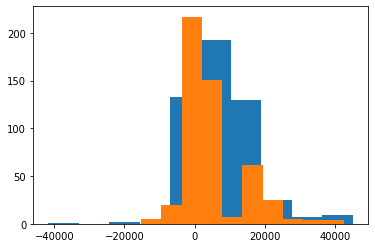

In [14]:
# Plot the difference in number of branches with mutation a and b
# Mutation a = mutation i, mutation b = mutation_j

results["difference_first_minus_second"] = results.n_branches_with_j - results.n_branches_with_i

figure = plt.figure()
ax = figure.gca()

hypergeo = results.query("pval_hypergeo_i_on_j_BH_sig").sort_values("pval_hypergeo_i_on_j_BH_sig")
beta = results.query("pval_beta_i_on_j_BH_sig").sort_values("pval_beta_i_on_j_BH_sig")


#ax.hist(results.difference_second_minus_first)
ax.hist(beta.iloc[0:500,:].difference_first_minus_second)
ax.hist(hypergeo.iloc[0:500,:].difference_first_minus_second)

<AxesSubplot:xlabel='n_branches_with_j', ylabel='Count'>

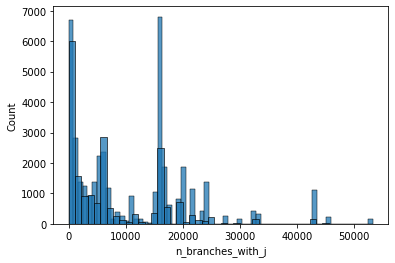

In [21]:
# Plot the difference in number of branches with mutation a and b
# Mutation a = mutation i, mutation b = mutation_j

results["difference_first_minus_second"] = results.n_branches_with_j - results.n_branches_with_i

figure = plt.figure()
ax = figure.gca()

hypergeo = results.query("pval_hypergeo_i_on_j_BH_sig").sort_values("pval_hypergeo_i_on_j_BH_sig")
beta = results.query("pval_beta_i_on_j_BH_sig").sort_values("pval_beta_i_on_j_BH_sig")


#ax.hist(results.difference_second_minus_first)
sns.histplot(beta.n_branches_with_j, ax=ax)
sns.histplot(hypergeo.n_branches_with_j,ax=ax)

In [62]:
beta.iloc[0:500,:].difference_first_minus_second.median()

5679.0

In [61]:
hypergeo.iloc[0:500,:].difference_first_minus_second.median()

2557.0

In [63]:
hypergeo.reset_index().query("position_j==761155 and position_i==764817") 

,index,position_i,position_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_branches_with_j,n_muts_i_on_branch_j,n_muts_j_on_branch_i,n_muts_same_branch,...,n_branch_with_j_no_i,n_branch_i_and_j,pval_beta_i_on_j,pval_hypergeo_i_on_j,pval_betabin_i_on_j,BH_critical_value,pval_beta_i_on_j_BH_sig,pval_hypergeo_i_on_j_BH_sig,difference_second_minus_first,difference_first_minus_second
13932,299609,764817,761155,277,1487,921,9165,78,3,105,...,8258,907,5.590614e-13,1.033296e-10,0.00131,0.000013,True,True,-8244,8244


In [64]:
beta.reset_index().query("position_j==761155 and position_i==764817")

,index,position_i,position_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_branches_with_j,n_muts_i_on_branch_j,n_muts_j_on_branch_i,n_muts_same_branch,...,n_branch_with_j_no_i,n_branch_i_and_j,pval_beta_i_on_j,pval_hypergeo_i_on_j,pval_betabin_i_on_j,BH_critical_value,pval_beta_i_on_j_BH_sig,pval_hypergeo_i_on_j_BH_sig,difference_second_minus_first,difference_first_minus_second
26457,299609,764817,761155,277,1487,921,9165,78,3,105,...,8258,907,5.590614e-13,1.033296e-10,0.00131,0.000013,True,True,-8244,8244


In [68]:
# compare to previous calculation
r = pd.read_csv("../DependentMutations/output/02.comutation_pvalues/results_file_allpairs.csv")
r = r.sort_values("pval_beta_i_on_j").reset_index()
r.query("position_j==761155 and position_i==764817")

,index,Unnamed: 0,position_i,position_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_branches_with_j,n_muts_i_on_branch_j,n_muts_j_on_branch_i,n_muts_same_branch,n_branch_with_i_no_j,n_branch_with_j_no_i,n_branch_i_and_j,pval_beta_i_on_j,BH_critical_value,pval_beta_i_on_j_BH_sig
276,276,267826,764817,761155,277,1487,921,9165,78,3,105,14,8258,907,7.321777e-78,0.000002,True


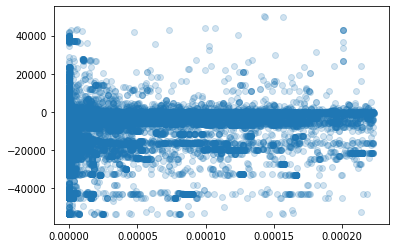

In [47]:
plt.scatter(results.query("pval_beta_i_on_j_BH_sig").pval_beta_i_on_j,
            results.query("pval_beta_i_on_j_BH_sig").difference_second_minus_first, alpha=0.2)

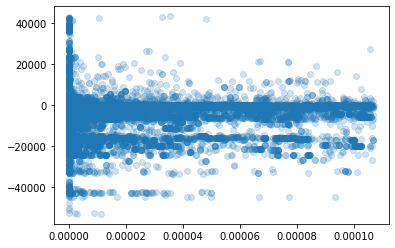

In [48]:
plt.scatter(results.query("pval_hypergeo_i_on_j_BH_sig").pval_hypergeo_i_on_j,
            results.query("pval_hypergeo_i_on_j_BH_sig").difference_second_minus_first, alpha=0.2)

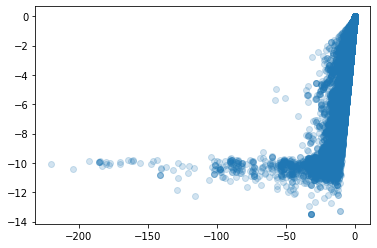

In [76]:
results = pd.read_csv("output/02A.comutation_pvalues/results_file_allpairs.csv", index_col=0)
results = benjamini_hochberg(results, "pval_hypergeo_i_on_j", threshold=0.01)
plt.scatter(np.log10(results.pval_beta_i_on_j), 
            np.log10(results.pval_hypergeo_i_on_j), alpha=0.2)

In [78]:
contrasts = results.query("pval_beta_i_on_j_BH_sig and not pval_hypergeo_i_on_j_BH_sig")
contrasts

,position_i,position_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_branches_with_j,n_muts_i_on_branch_j,n_muts_j_on_branch_i,n_muts_same_branch,n_branch_with_i_no_j,n_branch_with_j_no_i,n_branch_i_and_j,pval_beta_i_on_j,pval_hypergeo_i_on_j,pval_betabin_i_on_j,BH_critical_value,pval_beta_i_on_j_BH_sig,pval_hypergeo_i_on_j_BH_sig
562623,4386108,1340108,45,24,756,666,5,2,0,740,650,16,7.805009e-05,0.000107,0.255584,0.000107,True,False
560857,4386108,1340104,45,23,756,666,5,2,0,740,650,16,7.805009e-05,0.000107,0.255584,0.000107,True,False
561460,4386108,1340105,45,24,756,666,5,2,0,740,650,16,7.805009e-05,0.000107,0.255584,0.000107,True,False
562030,4386108,1340106,45,22,756,666,5,2,0,740,650,16,7.805009e-05,0.000107,0.255584,0.000107,True,False
862097,4057391,2339255,8,43,24,20062,8,0,0,0,20038,24,3.784106e-08,0.000107,0.000024,0.000107,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587381,2289072,1341044,18,8,72,53351,17,0,0,2,53281,70,8.030091e-05,0.219867,0.000186,0.002554,True,False
587767,2747141,1341044,18,8,26,53351,17,0,0,0,53325,26,8.088635e-05,0.220132,0.000187,0.002555,True,False
5410,1199,1341044,18,8,16,53351,17,0,0,0,53335,16,8.106571e-05,0.220213,0.000187,0.002555,True,False
309578,762285,1341044,18,8,92,53351,17,0,0,76,53335,16,8.912270e-05,0.223690,0.000203,0.002575,True,False


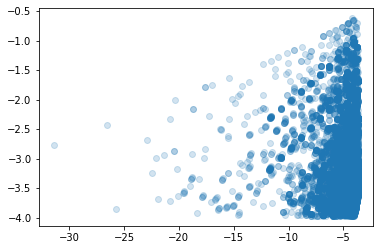

In [79]:
plt.scatter(np.log10(contrasts.pval_beta_i_on_j), 
            np.log10(contrasts.pval_hypergeo_i_on_j), alpha=0.2)

In [80]:
contrasts.sort_values("pval_beta_i_on_j")

,position_i,position_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_branches_with_j,n_muts_i_on_branch_j,n_muts_j_on_branch_i,n_muts_same_branch,n_branch_with_i_no_j,n_branch_with_j_no_i,n_branch_i_and_j,pval_beta_i_on_j,pval_hypergeo_i_on_j,pval_betabin_i_on_j,BH_critical_value,pval_beta_i_on_j_BH_sig,pval_hypergeo_i_on_j_BH_sig
587994,3073679,1341044,53,8,192,53351,52,0,0,0,53159,192,3.994986e-32,0.001721,9.620175e-30,0.000255,True,False
589171,4338365,1341044,48,8,46,53351,47,0,0,0,53305,46,2.580619e-27,0.003645,2.969227e-25,0.000353,True,False
888230,3730361,2626108,35,39,284,45234,34,0,0,14,44964,270,1.994101e-26,0.000140,5.793501e-23,0.000112,True,False
587732,2715344,1341044,75,8,526,53351,72,0,0,2,52827,524,1.222832e-23,0.002045,1.764917e-21,0.000274,True,False
588568,3847215,1341044,149,8,3830,53351,139,0,0,72,49593,3758,3.816786e-23,0.000568,1.396393e-20,0.000165,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309326,2999014,762089,5,6,2,444,2,0,0,2,444,0,2.231187e-04,0.000491,1.883241e-01,0.000160,True,False
930646,3013415,3529598,5,5,2,444,2,0,0,2,444,0,2.231187e-04,0.000491,1.883241e-01,0.000160,True,False
702520,3013415,1772288,5,7,2,444,2,0,0,2,444,0,2.231187e-04,0.000491,1.883241e-01,0.000160,True,False
702558,3767337,1772288,5,7,4,444,2,0,0,4,444,0,2.231329e-04,0.000491,1.883242e-01,0.000160,True,False


In [88]:
####Run the calculation for all the points in the dataset
df = pd.read_csv("output/01.mutation_and_comutation_data/combined_position.csv", index_col=0)

df = df.query("position_i==1341044 and position_j==3073679")
#
subset=apply_testing(df, run_hypergeometric=True, run_betabin=True, verbose=True)

running hypergeometric i on j
total branches:9495
total successes:0
total draws:8
Number of successful draws:0
pvalue:1.0
running hypergeometric j on i
total branches:62654.0
total successes:53159.0
total draws:53.0
Number of successful draws:52.0
pvalue:0.0017209447113686327
running beta-binomial i on j
running beta-binomial j on i
a_unmutated_branches: 1.0
b_unmutated_branches: 9494.0
a_mutated_branches: 52.0
b_mutated_branches: 53107.0
pvalue:9.620174757918891e-30
running beta i on j
running beta j on i
a_unmutated_branches: 1.0
b_unmutated_branches: 9494.0
a_mutated_branches: 52.0
b_mutated_branches: 53107.0
pvalue:3.994986461566666e-32


In [11]:
####Run the calculation for all the points in the dataset
df = pd.read_csv("output/01.mutation_and_comutation_data/combined_position.csv", index_col=0)

df = df.query("position_j==3730361 and position_i==2626108")
#
subset=apply_testing(df, run_hypergeometric=True, run_betabin=True, verbose=True)

running hypergeometric i on j
total branches:17612
total successes:14
total draws:39
Number of successful draws:0
pvalue:1.0
running hypergeometric j on i
total branches:62562.0
total successes:44964.0
total draws:35.0
Number of successful draws:34.0
pvalue:0.00013975169341728932
running beta-binomial i on j
running beta-binomial j on i
a_unmutated_branches: 1.0
b_unmutated_branches: 17597.0
a_mutated_branches: 34.0
b_mutated_branches: 44930.0
pvalue:5.793501176163194e-23
running beta i on j
running beta j on i
a_unmutated_branches: 1.0
b_unmutated_branches: 17597.0
a_mutated_branches: 34.0
b_mutated_branches: 44930.0
pvalue:1.9941005380288382e-26
